In [83]:
import numpy as np 
import pickle
import scipy.io as sio
import scipy.sparse as ss 

#import seaborn as sns

from sklearn.preprocessing import normalize
from sklearn.preprocessing import binarize
from sklearn.svm import LinearSVC, NuSVC, SVC 
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import metrics
import matplotlib.pyplot as plt
from collections import defaultdict 
import operator
from tqdm import tqdm

np.random.seed(12345)

from __future__ import division
import random
import shutil
import numpy as np
import torch
import torch.autograd
import torch.nn.functional as F
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.nn.parallel
from torch.autograd import Variable
from time import time
import nltk
from torchtext import vocab
from collections import defaultdict
import codecs
import json

In [19]:
glove = vocab.GloVe(name='6B', dim=50)
randomvec = glove.vectors[glove.stoi['the']].numpy()

In [16]:
training_caps = [c for c in json.load(open('data/foilv1.0_train2017.json'))['annotations']]
foiled_caps = [c for c in training_caps if c['foil_word'] != 'ORIG']


In [27]:
foiled_we = {}
correct_we = {} 

for c in foiled_caps:
    if c['foil_word'] != 'ORIG' and c['foil_word'] in glove.stoi:
#        print c['foil_word']
        foiled_we[c['image_id']] = glove.vectors[glove.stoi[c['foil_word']]].numpy()
        if c['target_word'] in glove.stoi:
            correct_we[c['image_id']] = glove.vectors[glove.stoi[c['target_word']]].numpy()
        else: 
            print c['target_word']
    elif c['foil_word'] != 'ORIG' and c['foil_word'] not in glove.stoi:
        print c['foil_word']
        foiled_we[c['image_id']] = randomvec
    

In [41]:
training_caps[0]
training_v2[0]

{u'POS': u'NA',
 u'Source': u'NA',
 u'caption': u'people preparing what they want to eat on a table',
 u'foil_id': 4000002,
 u'foil_word': u'ORIG',
 u'id': 491646,
 u'image_id': 405613,
 u'target_word': u'ORIG'}

In [76]:
training_v2 = [w for w in json.load(open('foil_new/FOIL-LINGv0.5_train2017.json'))['annotations']]

orig = [w['image_id'] for w in foiled_caps]
dup = [w['image_id'] for w in training_v2]
dupdict = defaultdict(list)
[dupdict[w['image_id']].append(w['POS']) for w in training_v2]
print len(orig), len(dup), len(set(orig)), len(set(dup))

same = []
diff = []
for c in orig:
    if c in dupdict: 
        for v in dupdict[c]:
            if v != 'NA':
                same.append((c, v))
            else: 
                diff.append(c)
#

#len(set(orig).intersection(dup))

fcaps = defaultdict(list)
[fcaps[w['image_id']].append((w['caption'], w['foil_word'])) for w in foiled_caps]

newcaps = defaultdict(list)
[newcaps[w['image_id']].append((w['caption'], w['foil_word'])) for w in training_v2]

print 'done'

153229 106691 69293 27758
done


In [84]:
newnounsamples = []

for c in tqdm(training_caps):
    if c['image_id'] in dup and c['foil_word'] != 'ORIG':
        newnounsamples.append(c)

len(newnounsamples)

100%|██████████| 306458/306458 [12:10<00:00, 419.48it/s]


51280

[{u'caption': u'a chair is adorned with wooden chairs with blue accents.',
  u'foil_id': 2000005,
  u'foil_word': u'chair',
  u'id': 794853,
  u'image_id': 57870,
  u'target_word': u'table'},
 {u'caption': u'a long toilet with a flower arrangement in the middle for meetings',
  u'foil_id': 2000006,
  u'foil_word': u'toilet',
  u'id': 791316,
  u'image_id': 57870,
  u'target_word': u'table'},
 {u'caption': u'the window above the kitchen oven is opened.',
  u'foil_id': 2000073,
  u'foil_word': u'oven',
  u'id': 665342,
  u'image_id': 44404,
  u'target_word': u'sink'},
 {u'caption': u'a fridge, sink and sink in the kitchen',
  u'foil_id': 2000074,
  u'foil_word': u'sink',
  u'id': 669281,
  u'image_id': 44404,
  u'target_word': u'microwave'},
 {u'caption': u'a kitchen has wood cabinets, a dishwasher, microwave, and refrigerator.',
  u'foil_id': 2000076,
  u'foil_word': u'microwave',
  u'id': 663785,
  u'image_id': 44404,
  u'target_word': u'sink'},
 {u'caption': u'a man is on his phone wh

In [3]:
class Net(nn.Module):
    '''
    A regressor 
    '''
    def __init__(self, dim1, dim2):
        super(Net, self).__init__()
        self.dim1 = dim1
        self.dim2 = dim2
        self.project = nn.Linear(self.dim1, self.dim2)
        
    def forward(self, x):
        out = self.project(x)
        return out

In [35]:
# training data:
# train_feats = BOW linguistic features
# train_image_feats = BOC image categorical features
# train_y = FOILED or NOT FOILED => IF FOILED = 1, else 0
train_feats = sio.mmread('data/train_feats.mtx')
train_image_feats = sio.mmread('data/train_image_feats.mtx')
train_target = np.array(sio.mmread('data/train_y.mtx').todense()).tolist()[0]
#############
# validation data: Same pattern as training; 
# The testing data comes from the karpathy 5k validation set only. 
val_feats = sio.mmread('data/test_feats.mtx')
val_image_feats = sio.mmread('data/test_image_feats.mtx')
val_target = np.array(sio.mmread('data/test_y.mtx').todense()).tolist()[0]

In [4]:
# Data processing, concatinating images with
# linguistic features and image features 
#X_train = ss.hstack([(train_feats), train_image_feats])
print train_image_feats.shape
X_train = ss.hstack([binarize(train_feats), binarize(train_image_feats)])

#X_val = ss.hstack([(val_feats), val_image_feats])
X_val = ss.hstack([binarize(val_feats), binarize(val_image_feats)])

Y_train = np.array(train_target)
Y_test = np.array(val_target)

(306458, 80)


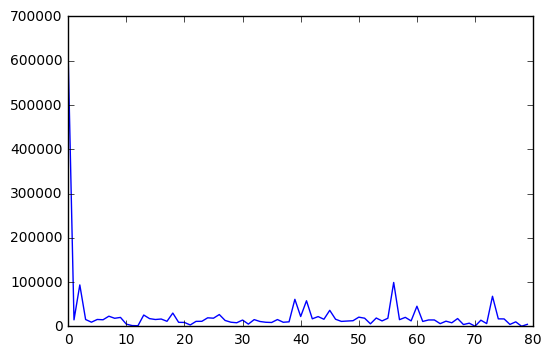

(78, 429.0)

In [5]:
#categories = binarize(train_image_feats).sum(axis=0).tolist()[0]
categories = (train_image_feats).sum(axis=0).tolist()[0]
plt.plot(categories)
plt.show()
np.array(categories).argmin(), categories[np.array(categories).argmin()]



In [7]:
#np.unique(.todense())
unique_stuff = np.vstack({tuple(row) for row in np.array(binarize(train_image_feats).todense())})


unique_arrays = {}
for row in np.array(binarize(train_image_feats).todense()):
    #unique_arrays[tuple(row)] += 1 
    if tuple(row) not in unique_arrays:
        unique_arrays[tuple(row)] = 1
    else:
        unique_arrays[tuple(row)] += 1 

sorted_unique_arrays = sorted(unique_arrays.items(), key=operator.itemgetter(1))


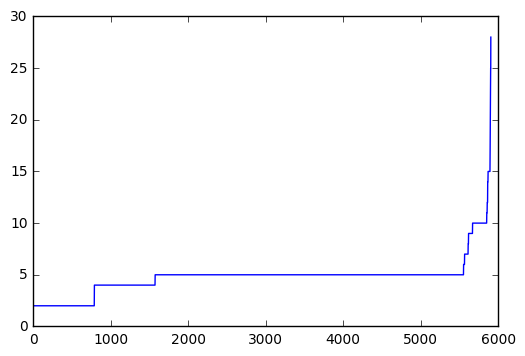

5906 2 28


In [8]:
unique_stuff = np.vstack({tuple(row) for row in np.array(binarize(val_image_feats).todense())})


unseen = {}
for row in np.array(binarize(val_image_feats).todense()):
    #unique_arrays[tuple(row)] += 1 
    if tuple(row) in unseen:
        unseen[tuple(row)] += 1  
    elif tuple(row) not in unique_arrays:
        unseen[tuple(row)] = 1

sorted_unseen = sorted(unseen.items(), key=operator.itemgetter(1))
unseen_plotting = [a[1] for a in sorted_unseen]
plt.plot(unseen_plotting)
plt.show()
print len(unseen), np.array(unseen_plotting).min(), np.array(unseen_plotting).max()



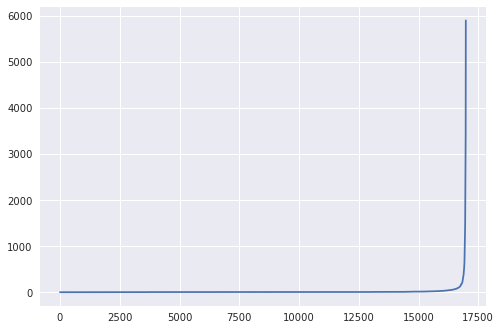

5900 2


In [90]:
numbers_only = [a[1] for a in sorted_unique_arrays]
plt.plot(numbers_only)
plt.show()
print np.array(numbers_only).max(), np.array(numbers_only).min() 

In [101]:
unique_stuff = np.vstack({tuple(row) for row in np.array((train_image_feats).todense())})


unique_arrays = {}
for row in np.array((train_image_feats).todense()):
    #unique_arrays[tuple(row)] += 1 
    if tuple(row) not in unique_arrays:
        unique_arrays[tuple(row)] = 1
    else:
        unique_arrays[tuple(row)] += 1 

sorted_unique_arrays = sorted(unique_arrays.items(), key=operator.itemgetter(1))


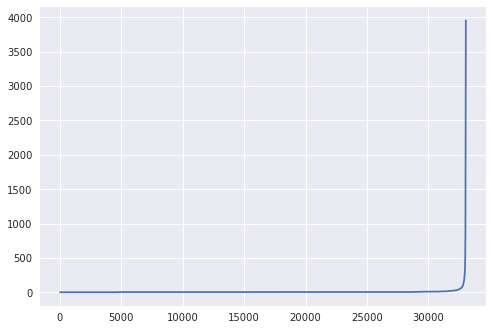

3953 2


In [92]:
numbers_only = [a[1] for a in sorted_unique_arrays]
plt.plot(numbers_only)
plt.show()
print np.array(numbers_only).max(), np.array(numbers_only).min() 

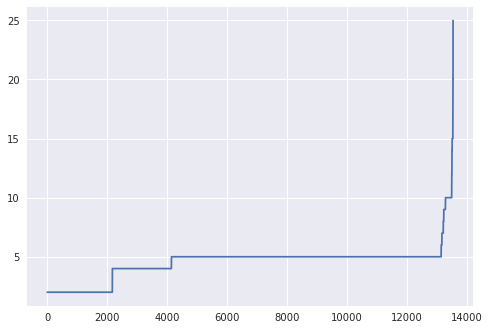

13530 2 25


(150556, 80)

In [111]:
unique_stuff = np.vstack({tuple(row) for row in np.array((val_image_feats).todense())})


unseen = {}
for row in np.array((val_image_feats).todense()):
    #unique_arrays[tuple(row)] += 1 
    if tuple(row) in unseen:
        unseen[tuple(row)] += 1  
    elif tuple(row) not in unique_arrays:
        unseen[tuple(row)] = 1

sorted_unseen = sorted(unseen.items(), key=operator.itemgetter(1))
unseen_plotting = [a[1] for a in sorted_unseen]
plt.plot(unseen_plotting)
plt.show()
print len(unseen), np.array(unseen_plotting).min(), np.array(unseen_plotting).max()

val_image_feats.shape

In [196]:
test_samples = dict([(w.strip().split()[0], np.array(map(float, w.strip().split()[1:]))) for
               w in open('data/mscoco_boc_gt_val2014.txt')])
unseen = {}
for key, value in test_samples.items():
    #unique_arrays[tuple(row)] += 1 
    if key in unseen:
    #    unseen[tuple(row)] += 1  
        print seen
    elif tuple(value) not in unique_arrays:
        unseen[key] = value
    
vocab = [r.strip().split()[1] for r in open('mscoco_boc_gt.vocab')]
#print len(test_sample)
print len(unseen)

with open('data/mscoco_boc_gt_unseen.txt', 'w') as f:
    for k,v in unseen.items():
        f.write('%s %s\n' %(k, ' '.join(map(str, v))))
        
with open('data/mscoco_boc_ft_unseen_categories.txt', 'w') as f:
    for k, v in unseen.items():
        f.write('%s %s\n' %(str(int(k.split('.jpg')[0].split('COCO_val2014_')[1])), ' '.join((np.array(vocab)[v >= 1]).tolist())))

training_image_feats = normalize(train_image_feats)
#train_image_feats = train_image_feats.todense()

#with open('data/mscoco_boc_ft_unseen_closest_match.txt', 'w') as f:
#    for k, v in unseen.items():
#        f.write('%s %s\n' %(str(int(k.split('.jpg')[0].split('COCO_val2014_')[1])), ' '.join((np.array(vocab)[np.array(train_image_feats[training_image_feats.dot(normalize(v)[0]).argmax()])[0] > 0]).tolist())))


17236


In [209]:
#training_image_feats.dot(normalize(v)).argmax()
#(np.array(vocab)[np.array(train_image_feats[training_image_feats.dot(normalize(v)[0]).argmax()])[0] > 0]).tolist()
#train_image_feats = train_image_feats.todense()
print train_image_feats.shape
print training_image_feats.dot(normalize(v)[0]).argsort()[::-1][:6]
print(np.array(vocab)[np.array(train_image_feats[34284])[0] > 0]).tolist()
print train_image_feats[34284]
print(np.array(vocab)[np.array(train_image_feats[34286])[0] > 0]).tolist()
print train_image_feats[34286]
print(np.array(vocab)[np.array(train_image_feats[34287])[0] > 0]).tolist()
print np.array(train_image_feats[34287])
print 'odd'
print(np.array(vocab)[np.array(train_image_feats[233864])[0] > 0]).tolist()
print np.array(train_image_feats[233864])

print (np.array(vocab)[v >= 1]).tolist()
print v
print k


(306458, 80)
[ 34284  34286  34287  34283  34285 233864]
['person', 'bottle', 'bowl', 'banana', 'apple', 'orange', 'cake', 'chair', 'potted_plant', 'dining_table']
[[ 2.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  9.  0.  0.  0.  0.  0.  2.  2.  3.  0.  2.  0.  0.  0.  0.
   0.  1.  1.  0.  1.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.]]
['person', 'bottle', 'bowl', 'banana', 'apple', 'orange', 'cake', 'chair', 'potted_plant', 'dining_table']
[[ 2.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  9.  0.  0.  0.  0.  0.  2.  2.  3.  0.  2.  0.  0.  0.  0.
   0.  1.  1.  0.  1.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.]]
['person', 'bottle', 'bowl', 'banana', 'apple', 'orange', 'cake',

/home/pranava/miniconda2/envs/pytorch2/lib/python2.7/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


In [207]:
tif= dict([(tuple(map(float, r.strip().split()[1:])), r.strip().split()[0]) for r 
                      in open('data/mscoco_boc_gt_train2014.txt')])

print train_image_feats[34284].tolist()[0]
print tif[tuple(train_image_feats[34286].tolist()[0])]

[2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 2.0, 3.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
COCO_train2014_000000069048.jpg


In [ ]:
(tuple(map(float, r.strip().split()[1:]))

In [46]:
# Logistic Regression with 'l1' penalty
logistic = LogisticRegression(penalty='l1')
logistic.fit(X_train, Y_train)
print 'Accuracy = ', metrics.accuracy_score(Y_test, logistic.predict(X_val))
target_names = ['REAL', 'FAKE']
print metrics.classification_report(Y_test, logistic.predict(X_val), 
                                    target_names=target_names)

Accuracy =  0.757631711788
             precision    recall  f1-score   support

       REAL       0.77      0.73      0.75     75278
       FAKE       0.75      0.78      0.76     75278

avg / total       0.76      0.76      0.76    150556



In [47]:
# Linear Support Vector Classifier with l2 regularizer and hinge loss
linearsvc = LinearSVC(penalty='l2', loss='hinge', verbose=1)
linearsvc.fit(X_train, Y_train)
print 'Accuracy = ', metrics.accuracy_score(Y_test, linearsvc.predict(X_val))
target_names = ['REAL', 'FAKE']
print metrics.classification_report(Y_test, linearsvc.predict(X_val), 
                                    target_names=target_names)

[LibLinear]Accuracy =  0.758966763198
             precision    recall  f1-score   support

       REAL       0.80      0.69      0.74     75278
       FAKE       0.73      0.83      0.77     75278

avg / total       0.76      0.76      0.76    150556



In [43]:
# Decision tree classifier
decisiontree = DecisionTreeClassifier(random_state=0)
decisiontree.fit(X_train, Y_train)
print 'Accuracy = ', metrics.accuracy_score(Y_test, decisiontree.predict(X_val))
target_names = ['REAL', 'FAKE']
print metrics.classification_report(Y_test, decisiontree.predict(X_val), 
                                    target_names=target_names)

Accuracy =  0.960273918011
             precision    recall  f1-score   support

       REAL       0.96      0.96      0.96     75278
       FAKE       0.96      0.96      0.96     75278

avg / total       0.96      0.96      0.96    150556



In [44]:
# standard Gradient Boosting Classifier 
gb = GradientBoostingClassifier()
gb.fit(X_train, Y_train)
print 'Accuracy = ', metrics.accuracy_score(Y_test, gb.predict(X_val.toarray()))
target_names = ['REAL', 'FAKE']
print metrics.classification_report(Y_test, gb.predict(X_val.toarray()), 
                                    target_names=target_names)

Accuracy =  0.824098674247
             precision    recall  f1-score   support

       REAL       0.75      0.97      0.85     75278
       FAKE       0.95      0.68      0.79     75278

avg / total       0.85      0.82      0.82    150556



In [45]:
# extremely randomized tree classifier.
ert = ExtraTreeClassifier(splitter='best')
ert.fit(X_train, Y_train)
print 'Accuracy = ', metrics.accuracy_score(Y_test, ert.predict(X_val.toarray()))
target_names = ['REAL', 'FAKE']
print metrics.classification_report(Y_test, ert.predict(X_val), 
                                    target_names=target_names)

Accuracy =  0.768750498154
             precision    recall  f1-score   support

       REAL       0.77      0.77      0.77     75278
       FAKE       0.77      0.76      0.77     75278

avg / total       0.77      0.77      0.77    150556



In [ ]:
pickle.dump(decisiontree, open('decisiontreeclassifiermodel.pkl', 'w'))

In [8]:
# MLP Classifier as in the FOIL paper
mlp = MLPClassifier(solver='lbfgs', alpha=1e-5, random_state=1)
mlp.fit(X_train, Y_train)
print 'Accuracy = ', metrics.accuracy_score(Y_test, mlp.predict(X_val.toarray()))
target_names = ['REAL', 'FAKE']
print metrics.classification_report(Y_test, mlp.predict(X_val), 
                                    target_names=target_names)

Accuracy =  0.956932968464
             precision    recall  f1-score   support

       REAL       0.96      0.95      0.96     75278
       FAKE       0.95      0.96      0.96     75278

avg / total       0.96      0.96      0.96    150556



In [221]:
print metrics.classification_report(Y_test, mlp.predict(X_val), 
                                    target_names=target_names, digits=4)

             precision    recall  f1-score   support

       REAL     0.9623    0.9613    0.9618     75278
       FAKE     0.9614    0.9623    0.9618     75278

avg / total     0.9618    0.9618    0.9618    150556



In [222]:
a = mlp.predict(X_val)

In [226]:
Y_test.sum()

75278

In [229]:
a.sum() / float(Y_test.sum())

1.0009963070219718